In [1]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
from pandas import DataFrame

### Data

In [2]:
data = scipy.io.loadmat('Data/Traffic01/traffic_dataset.mat')

In [3]:
X = data['tra_X_te']
Y = data['tra_Y_te']
adj = data['tra_adj_mat']

In [4]:
data2 = pd.read_csv('Data/Traffic02/PeMSD7_V_228.csv', header=None).to_numpy()
data2.shape

(12672, 228)

In [5]:
t2 = 5/60*np.arange(data2.shape[0])

In [6]:
def save_fig(name):
    plt.savefig('images/' + name + '.png', format='png', dpi=400)

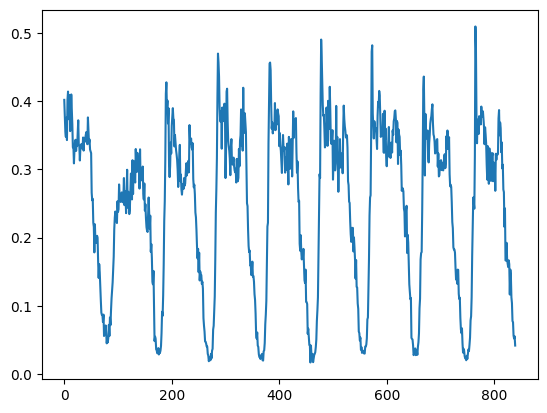

In [7]:
plt.plot(Y[0])

In [8]:
for i in range(len(X[0])):
    X[0, i] = X[0, i].todense()

In [9]:
x = np.empty(len(X[0]))
for i in range(len(X[0])):
    x[i] = X[0, i][0, 0]

x_df = DataFrame(x)

x = data2[:, 0]

In [41]:
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 16
})

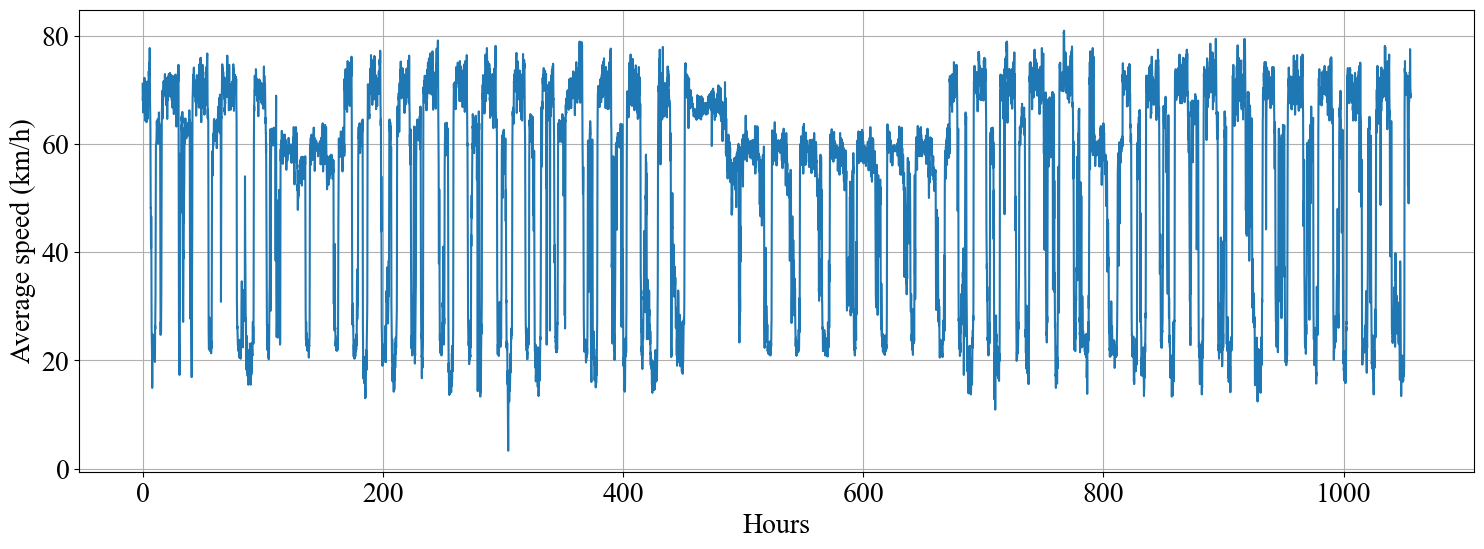

In [11]:
plt.figure(figsize=(18,6))
plt.plot(t2, x)
plt.xlabel('Hours')
plt.ylabel('Average speed (km/h)')
plt.grid()
save_fig('complete_time_series_ex')

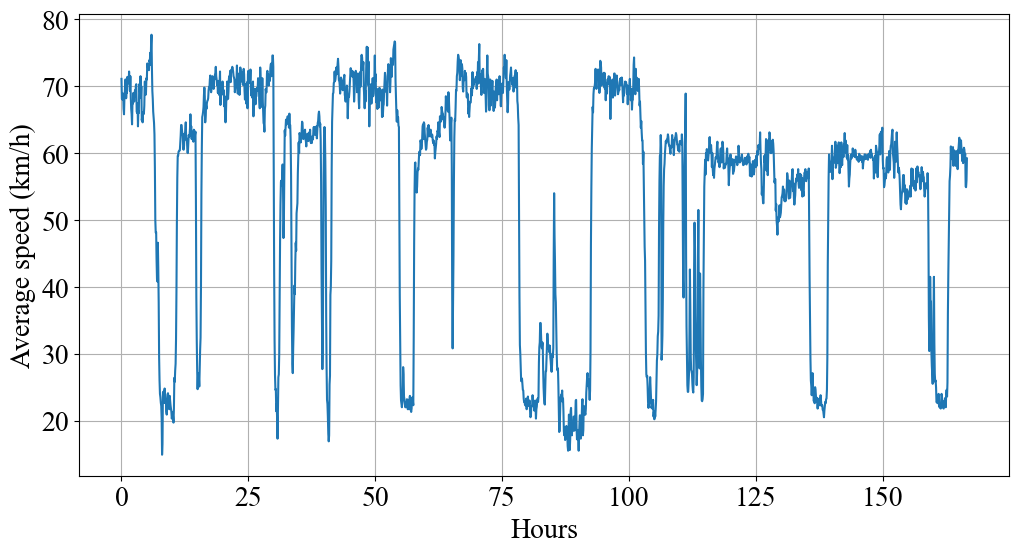

In [12]:
plt.figure(figsize=(12,6))
plt.plot(t2[:2000], x[:2000])
plt.xlabel('Hours')
plt.ylabel('Average speed (km/h)')
plt.grid()
plt.savefig('images/' + 'timeSeries_ex' + '.png', format='png', dpi=400)

### ARIMA and SARIMA Methods

In [13]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [14]:
adfuller(x)[1]

4.548618937344271e-25

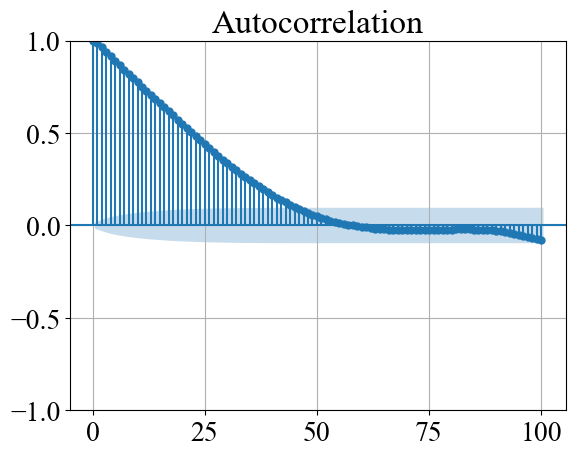

In [15]:
plot_acf(x, lags=100)
plt.grid()
save_fig('autocorr')

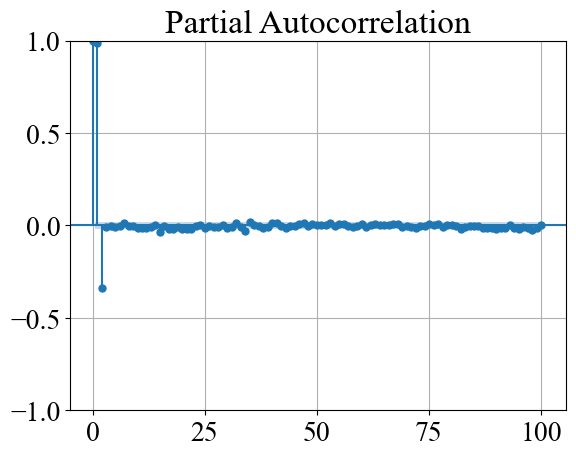

In [16]:
plot_pacf(x, lags=100)
plt.grid()
save_fig('partial_autocorrelation')

In [17]:
from pandas.plotting import autocorrelation_plot

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

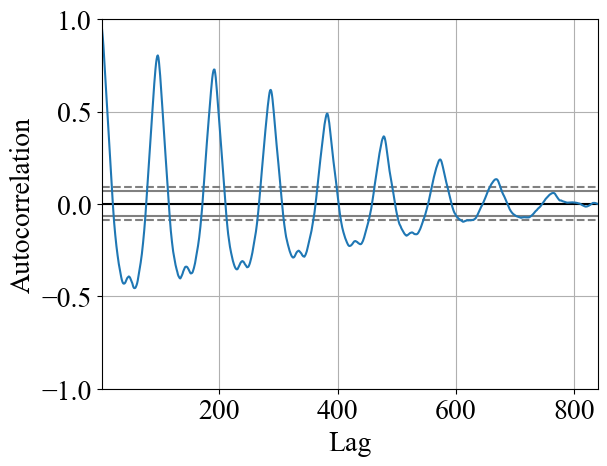

In [18]:
autocorrelation_plot(x_df)

In [19]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

In [20]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error

In [21]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
 dataset = dataset.astype('float32')
 best_score, best_cfg = float("inf"), None
 for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            print(f'order = {order}')
            mse = evaluate_arima_model(dataset, order)
            if mse < best_score:
                best_score, best_cfg = mse, order
                print('ARIMA%s MSE=%.5f' % (order,mse))
 
 print('Best ARIMA%s MSE=%.5f' % (best_cfg, best_score))

In [22]:
import warnings
warnings.filterwarnings("ignore")

In [23]:
p_val = range(1, 4)
d_val = [0, 1]
q_val = range(1, 4)
size = 1000
#evaluate_models(x[:1000], p_val, d_val, q_val)

In [25]:
x_red = x[:2000]
t2_red = t2[:2000]

In [26]:
model = ARIMA(x_red, order=(1,0,2))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2000
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -4847.651
Date:                Thu, 13 Jun 2024   AIC                           9705.301
Time:                        03:44:01   BIC                           9733.306
Sample:                             0   HQIC                          9715.584
                               - 2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         54.8451      3.497     15.685      0.000      47.992      61.698
ar.L1          0.9707      0.007    147.980      0.000       0.958       0.984
ma.L1          0.3827      0.012     31.873      0.0

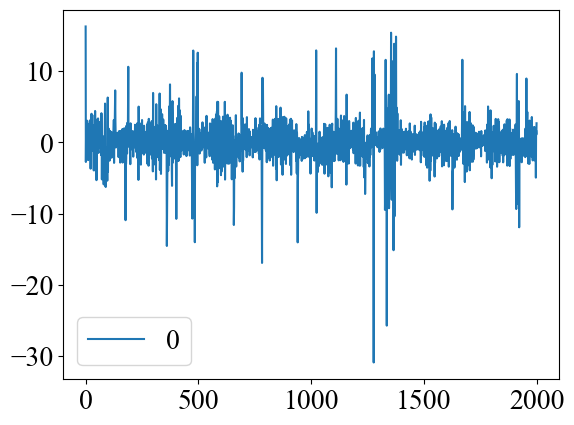

In [27]:
residuals = DataFrame(model_fit.resid)
residuals.plot()
save_fig('residuals')

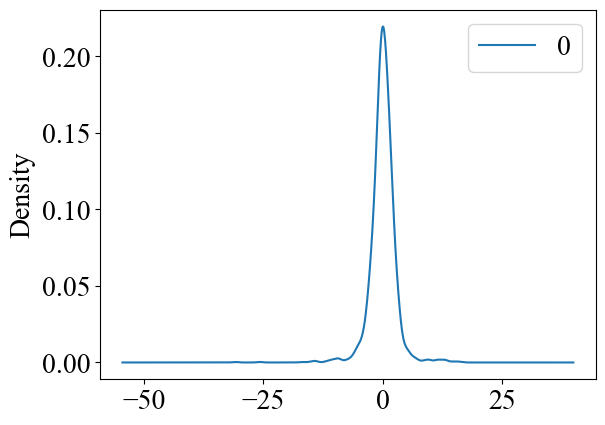

In [28]:
residuals.plot(kind='kde')
save_fig('residuals_kde')

In [29]:
print(residuals.describe())

                 0
count  2000.000000
mean      0.004458
std       2.753255
min     -30.906096
25%      -1.110072
50%       0.051182
75%       1.242622
max      16.254878


In [34]:
size = int(0.75*len(x_red))
train, test = x_red[:size], x_red[size:]
model = ARIMA(train, order=(1,0,2))
model_fit = model.fit()
output = model_fit.forecast(steps=5)
print(output)

[58.72872954 58.63682741 58.55234802 58.47045245 58.3910617 ]


In [30]:
def forecast(x, split, steps=1, print_res=True):
    size = int(len(x)*split)
    train, test = x[:size], x[size:]
    history = [x for x in train]
    predictions = list()
    t=0
    while t < len(test):
        model = ARIMA(history, order=(1,0,2))
        model_fit = model.fit()
        output = model_fit.forecast(steps=steps)
        if steps == 1:
            yhat = output[0]
            predictions.append(yhat)
            obs = test[t]
            history.append(obs)
            t += 1
            if print_res:
                print(f'predicted = {yhat}, expected = {obs}')
        else:
            for yhat in output:
                if (t >= len(test)): break
                predictions.append(yhat)
                obs = test[t]
                history.append(obs)
                t += 1
    return predictions, train, test

In [31]:
def forecast_test(x, split, steps=1, print_res=True):
    size = int(len(x)*split)
    train, test = x[:size], x[size:]
    history = [x for x in train]
    predictions = list()
    t=0
    while t < len(test):
        model = ARIMA(history, order=(1,0,2))
        model_fit = model.fit()
        output = model_fit.forecast(steps=steps)
        if steps == 1:
            yhat = output[0]
            predictions.append(yhat)
            obs = test[t]
            history.append(yhat)
            t += 1
            if print_res:
                print(f'predicted = {yhat}, expected = {obs}')
        else:
            for yhat in output:
                if (t >= len(test)): break
                predictions.append(yhat)
                obs = test[t]
                history.append(obs)
                t += 1
    return predictions, train, test

In [32]:
steps = [1, 5, 10]
pred = []
tests = []
for step in steps:
    predictions, _, test = forecast(x_red, 0.8, step, False)
    pred.append(predictions)

    tests.append(test)

In [33]:
for prediction, test in zip(pred, tests):
    rmse = np.sqrt(mean_squared_error(test, prediction))
    mae = mean_absolute_error(test, prediction)
    print(f'test RMSE = {rmse:.5f}')
    print(f'test MAE = {mae:.5f}')

test RMSE = 2.23408
test MAE = 1.51737
test RMSE = 4.44907
test MAE = 2.63656
test RMSE = 5.95328
test MAE = 3.65469


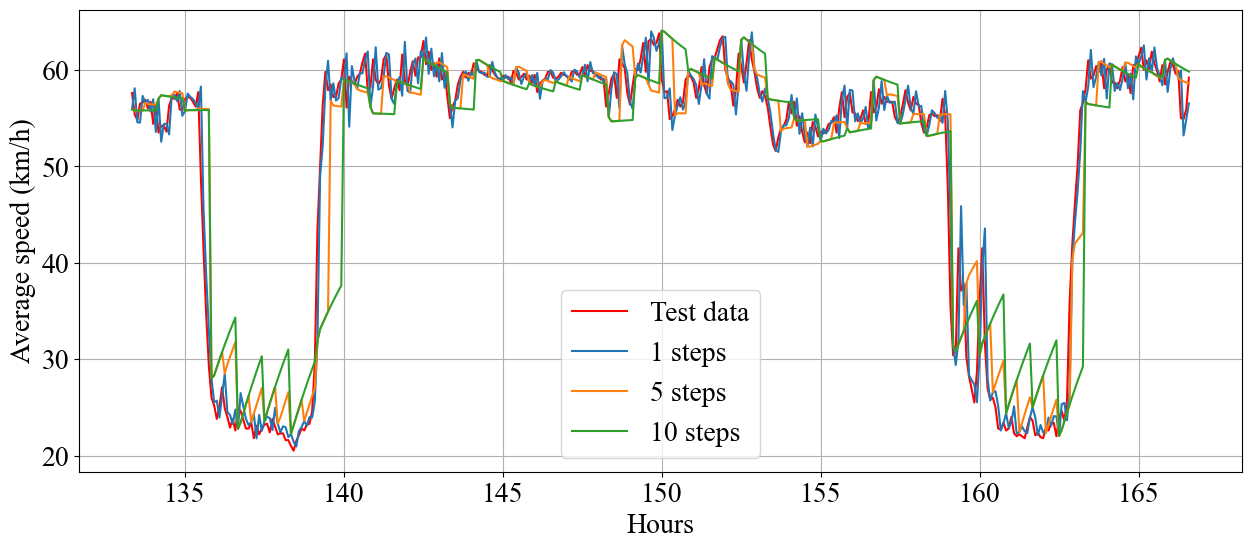

In [34]:
plt.figure(figsize=(15, 6))
plt.plot(t2_red[int(len(x_red)-len(predictions)):], x_red[int(len(x_red)-len(predictions)):], label='Test data', color='r')
for predictions, step in zip(pred, steps):
    plt.plot(t2_red[int(len(x_red)-len(predictions)):], predictions, label=f'{step} steps')
plt.ylabel('Average speed (km/h)')
plt.xlabel('Hours')
plt.legend()
plt.grid()

save_fig('arima_comparison')

In [50]:
rmse = [[], [], []]
mae = [[], [], []]
i=0
for prediction, test in zip(pred, tests):
    for yhat, y in zip(prediction, test):
        rmse[i].append(np.sqrt(mean_squared_error([y], [yhat])))
        mae[i].append(mean_absolute_error([y], [yhat]))
    i += 1

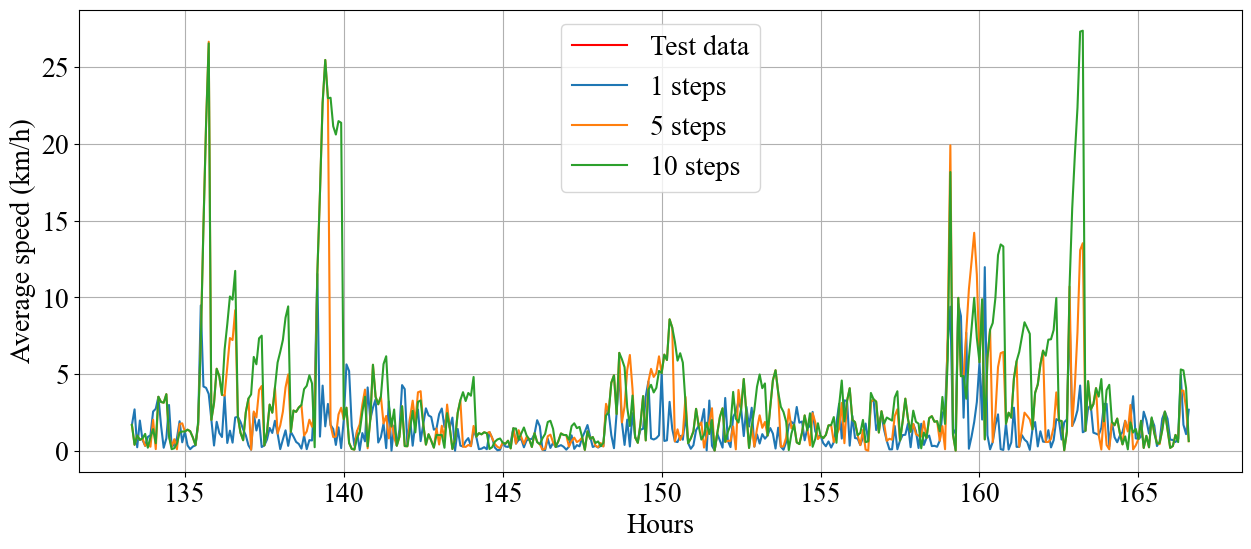

In [51]:
plt.figure(figsize=(15, 6))
plt.plot(t2_red[int(len(x_red)-len(predictions)):], x_red[int(len(x_red)-len(predictions)):], label='Test data', color='r')
for predictions, step in zip(mae, steps):
    plt.plot(t2_red[int(len(x_red)-len(predictions)):], predictions, label=f'{step} steps')
plt.ylabel('Average speed (km/h)')
plt.xlabel('Hours')
plt.legend()
plt.grid()

In [35]:
steps2 = [x for x in range(1, 30)]
mae = list()
rmse = list()

for step in steps2:
    predictions, _, test = forecast(x_red, 0.8, step, False)
    rmse.append(np.sqrt(mean_squared_error(test, predictions)))
    mae.append(mean_absolute_error(test, predictions))

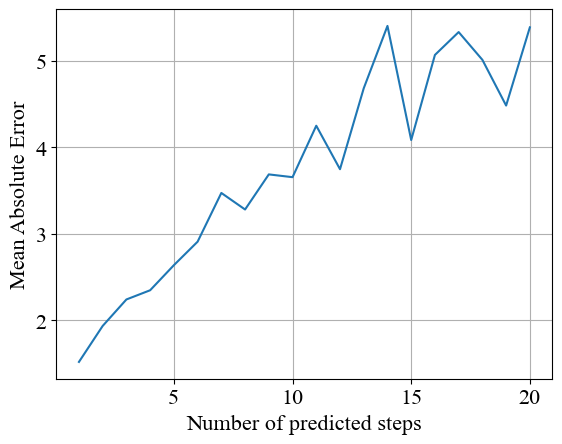

In [42]:
plt.plot(steps2[:20], mae[:20])
plt.grid()
plt.xlabel('Number of predicted steps')
plt.ylabel('Mean Absolute Error')
save_fig('mae')

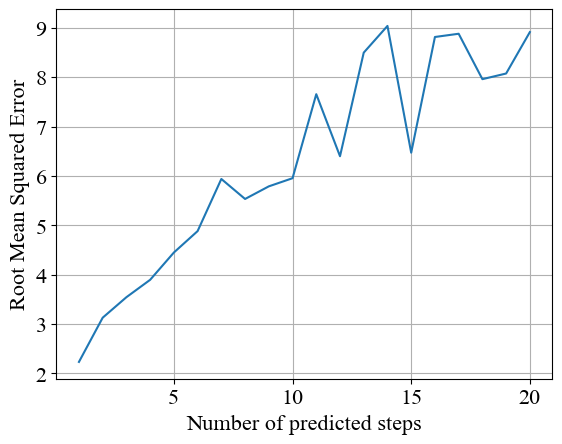

In [43]:
plt.plot(steps2[:20], rmse[:20])
plt.grid()
plt.xlabel('Number of predicted steps')
plt.ylabel('Root Mean Squared Error')
save_fig('rmse')

In [49]:
split = 0.25
xlen = 100
pred0, _, test0 = forecast(x_red[:xlen], split, print_res=False)
print(f'RMSE = {np.sqrt(mean_squared_error(test0, pred0)):.5f}')
print(f'MAE = {mean_absolute_error(test0, pred0):.5f}')

RMSE = 2.99855
MAE = 2.24206


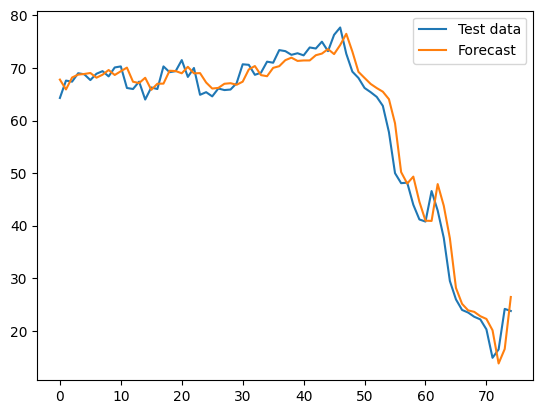

In [50]:
plt.plot(test0, label='Test data')
plt.plot(pred0, label='Forecast')
plt.legend()

In [ ]:
split = [0.25, 0.5, ]
x_len = [200, 200, 400, 600, 800, 1000]
mae = list()
rmse = list()

for s in split:
    print(s)
    predictions, _, test = forecast(x_red, s, False)
    rmse.append(np.sqrt(mean_squared_error(test, predictions)))
    mae.append(mean_absolute_error(test, predictions))